# Motivation

Being able to accurately forecast the volatile demand for power, especially across low-voltage distribution grids, is increasingly important to providing sufficent energy supply. Paradoxically, it's at the low-voltage networks that are the most volatile, and yet the most critical to account for as more distributed energy resources (e.g., solar, storage) make their way onto the grid. From the grid operator's point of view, not only are lower voltage service points (e.g., customers) the revenue life blood of the business, having increased visibility into demand at such lower levels of aggregation helps to provide 


In this notebook, I explore looking at a [Kaggle data set](https://www.kaggle.com/jeanmidev/smart-meters-in-london) containing about 5,000 utility service points with time series data from advanced metering infrastructure (AMI). The context of this experiment is to simulate the needs of a utility or grid operator and generate accurate short-term (up to 7 days ahead) forecast. I explore possible approaches that involve

- *Feature-based modeling approaches*
- *Customer Segmentation + Clustering*
- *Statistical methods, ML methods, and hybrid cross-learning approaches*

Performance is evaluated using time-series cross-validation using a rolling 7-day forecast horizon.

Finally, I show how this solution might be scaled and put into production.

Keywords: *time series classification*, *energy forecasting*, *cross-learning*, *MLOps*


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from tqdm import tqdm

import keras
import tensorflow

from tsfeatures import tsfeatures
from tsfeatures import crossing_points, acf_features, stl_features, entropy, nonlinearity, stability
import tsfeatures

Using TensorFlow backend.


In [2]:
# Set Project Working Directory
project_path = '/workspace/portfolio'

os.chdir(project_path)

# Set Data Path
data_path = f"{project_path}/data"
data_path

'/workspace/portfolio/data'

# Data

The data set we will use contains high-frequency measures of electricity demand usage across a panel of approximately 5,000 homes. It also contains customer metadata from the [ACORN](https://acorn.caci.co.uk/downloads/Acorn-User-guide.pdf) network, as well as atmospheric weather data from the DarkSky API (now owned by Apple and will be sunset by 2022).

In [3]:
# Process AMI Data
# The smart meter data is stored at the half-hour level of granularity in series of CSV files. 
# Here, we iterate over the files and concatenate into a single data frame in 'wide' format

ami_files = os.listdir(data_path + "/hhblock_dataset/hhblock_dataset/")

# Iterate over files using list comprehension
df_from_each_file = (pd.read_csv(data_path + "/hhblock_dataset/hhblock_dataset/" + f, sep=',') for f in ami_files)

df_merged   = pd.concat(df_from_each_file, ignore_index=True)
df_merged.head()


,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000013,2012-06-22,0.127,0.113,0.076,0.109,0.120,0.096,0.113,0.148,...,0.086,0.154,0.121,0.102,0.131,0.121,0.082,0.096,0.127,0.126
1,MAC000013,2012-06-23,0.106,0.135,0.228,0.079,0.109,0.117,0.079,0.122,...,0.107,0.113,0.106,0.077,0.119,0.126,0.151,0.135,0.108,0.093
2,MAC000013,2012-06-25,0.099,0.119,0.169,0.136,0.109,0.090,0.132,0.131,...,0.140,0.135,0.134,0.106,0.131,0.169,0.170,0.141,0.163,0.137
3,MAC000013,2012-06-26,0.142,0.103,0.117,0.136,0.127,0.129,0.150,0.137,...,0.136,0.136,0.304,0.159,0.126,0.145,0.196,0.158,0.173,0.149
4,MAC000013,2012-06-27,0.126,0.128,0.175,0.163,0.119,0.103,0.128,0.141,...,0.170,0.144,0.098,0.183,0.316,0.190,0.121,0.176,0.158,0.146


In [4]:
# Process Hourly Weather Data
wthr = pd.read_csv(data_path + "/weather_hourly_darksky.csv")

wthr = wthr.rename(columns = {"time":"timestamp"})

wthr['date'] = pd.to_datetime(wthr['timestamp']).dt.date.astype(str)
wthr['time'] = pd.to_datetime(wthr['timestamp']).dt.time.astype(str)
wthr['hour'] = pd.to_datetime(wthr['timestamp']).dt.hour.astype(int)
wthr.head()

,visibility,windBearing,temperature,timestamp,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,date,time,hour
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy,2011-11-11,00:00:00,0
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy,2011-11-11,01:00:00,1
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy,2011-11-11,02:00:00,2
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy,2011-11-11,03:00:00,3
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy,2011-11-11,04:00:00,4


In [ ]:
# Visualize Aggregate Loads and Temperature Data

#df_agg = df_merged.drop("LCLid", axis = 1).groupby("day").agg(["mean"])
df_agg = df_merged.groupby(["LCLid", "day"]).agg(["mean"])

#df_agg.columns = df_merged.filter(like='hh_').columns
#df_agg["day"] = df_agg.index

#df = (pd.wide_to_long(df_agg, stubnames = "hh_", i = ['day'], j = "hh")
#    .sort_values(["day", "hh"])
#    .reset_index()
#    .rename(columns={'hh_':'kw'}))

#lookup = pd.read_csv(data_path + "/time-lookup.csv", sep = ",")
#lookup['timestamp'] = pd.to_datetime(lookup['time'])
#lookup['time'] = lookup["timestamp"].dt.time
#lookup['hour'] = lookup["timestamp"].dt.hour

                     
#df = (df.join(lookup.set_index('hh'), how = "inner", on = "hh")
#    .rename(columns = {"day":"date"})
#    .sort_values(["date", "time"]))

# Aggregate to hourly for joining with weather data
#df = df.groupby(["date", "hour"]).agg(kw = ("kw", sum)).reset_index()

#df = pd.merge(df, wthr, on = ["date", "hour"])
#df.head()
df_agg.head()


In [6]:
del df_agg

<AxesSubplot:xlabel='temperature', ylabel='kw'>

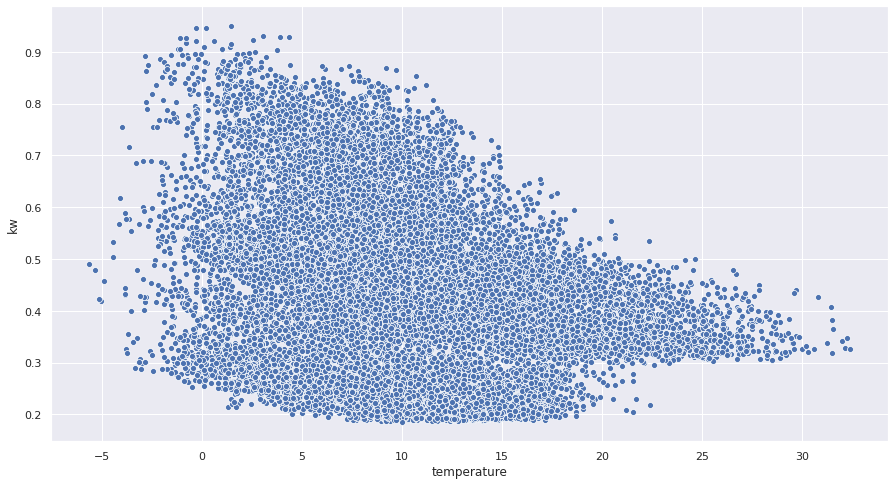

In [7]:
# Visualize Temperature * Load Relationship 
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(data = df, x = "temperature", y = "kw")

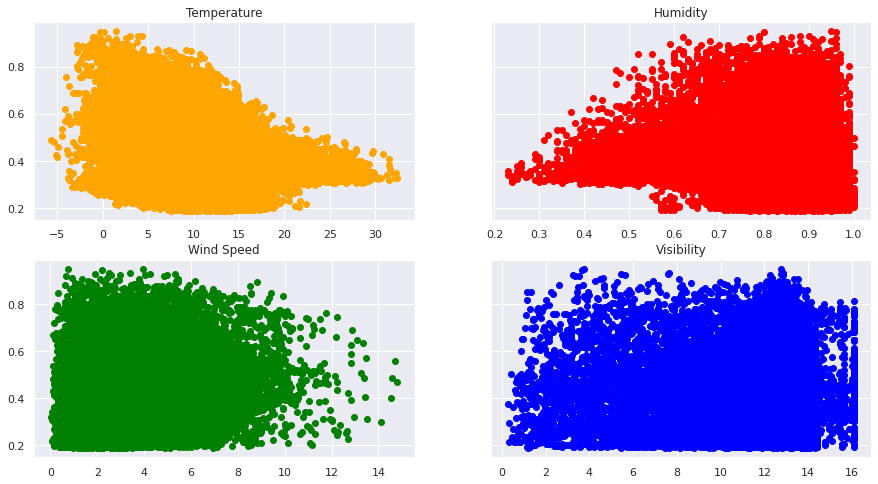

In [7]:

plt.rcParams["figure.figsize"] = (15, 8)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, sharey = True)
ax1.scatter(df.temperature, df.kw, c = "orange")
ax2.scatter(df.humidity, df.kw, c = "red")
ax3.scatter(df.windSpeed, df.kw, c = "green")
ax4.scatter(df.visibility, df.kw, c = "blue")
ax1.title.set_text('Temperature')
ax2.title.set_text('Humidity')
ax3.title.set_text('Wind Speed')
ax4.title.set_text('Visibility')

In [8]:
### Process Household Metadata ###

#
hh_info = pd.read_csv(data_path + "/acorn_details.csv", encoding = 'unicode_escape')
hh_info.head()

#
hh_info = pd.read_csv(data_path + "/informations_households.csv")
hh_info["Acorn"].value_counts()

ACORN-E    1567
ACORN-Q     831
ACORN-F     684
ACORN-H     455
ACORN-L     342
ACORN-D     292
ACORN-G     205
ACORN-K     165
ACORN-A     157
ACORN-N     152
ACORN-C     151
ACORN-M     113
ACORN-J     112
ACORN-P     110
ACORN-O     103
ACORN-I      51
ACORN-U      49
ACORN-B      25
ACORN-        2
Name: Acorn, dtype: int64

In [9]:
import gc
gc.collect()

59493

In [10]:
# Unique Number of Sensor meters
ids = pd.DataFrame(df_merged['LCLid'].unique())
ids.columns = ['id']
ids.shape

(5560, 1)

In [11]:
df.head()

,date,hour,kw,visibility,windBearing,temperature,timestamp,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,time
0,2011-11-24,0,0.400077,8.88,217,9.01,2011-11-24 00:00:00,8.33,1029.52,7.37,2.92,rain,clear-night,0.96,Clear,00:00:00
1,2011-11-24,1,0.595538,9.91,222,8.99,2011-11-24 01:00:00,8.04,1029.40,7.51,2.67,rain,clear-night,0.94,Clear,01:00:00
2,2011-11-24,2,0.461692,9.27,215,8.56,2011-11-24 02:00:00,7.97,1029.38,7.01,2.65,rain,clear-night,0.96,Clear,02:00:00
3,2011-11-24,3,0.281385,8.21,221,9.03,2011-11-24 03:00:00,8.36,1029.18,7.32,3.05,rain,clear-night,0.96,Clear,03:00:00
4,2011-11-24,4,0.273154,8.93,215,8.78,2011-11-24 04:00:00,8.19,1028.89,7.01,3.06,rain,clear-night,0.96,Clear,04:00:00


In [12]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,34 days 0 hours 3 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_nkjvh9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.734 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [17]:
# Set Seed
seed = 1234

# Read in Relevant Data
#hdf = h2o.H2OFrame(df.drop(['LSOA_of_Accident_Location', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Accident_Index'], axis = 1))
hdf = h2o.H2OFrame(df)
hdf.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


date,hour,kw,visibility,windBearing,temperature,timestamp,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,time
2011-11-24 00:00:00,0,0.400077,8.88,217,9.01,2011-11-24 00:00:00,8.33,1029.52,7.37,2.92,rain,clear-night,0.96,Clear,1970-01-01 00:00:00
2011-11-24 00:00:00,1,0.595538,9.91,222,8.99,2011-11-24 01:00:00,8.04,1029.4,7.51,2.67,rain,clear-night,0.94,Clear,1970-01-01 01:00:00
2011-11-24 00:00:00,2,0.461692,9.27,215,8.56,2011-11-24 02:00:00,7.97,1029.38,7.01,2.65,rain,clear-night,0.96,Clear,1970-01-01 02:00:00
2011-11-24 00:00:00,3,0.281385,8.21,221,9.03,2011-11-24 03:00:00,8.36,1029.18,7.32,3.05,rain,clear-night,0.96,Clear,1970-01-01 03:00:00
2011-11-24 00:00:00,4,0.273154,8.93,215,8.78,2011-11-24 04:00:00,8.19,1028.89,7.01,3.06,rain,clear-night,0.96,Clear,1970-01-01 04:00:00
2011-11-24 00:00:00,5,0.229538,9.91,213,9.59,2011-11-24 05:00:00,8.69,1029.07,8.05,2.96,rain,partly-cloudy-night,0.94,Partly Cloudy,1970-01-01 05:00:00
2011-11-24 00:00:00,6,0.237846,8.26,209,9.08,2011-11-24 06:00:00,8.25,1029.15,7.73,2.51,rain,partly-cloudy-night,0.95,Partly Cloudy,1970-01-01 06:00:00
2011-11-24 00:00:00,7,0.309231,9.32,201,8.76,2011-11-24 07:00:00,8.62,1029.11,7.41,2.43,rain,partly-cloudy-night,0.99,Partly Cloudy,1970-01-01 07:00:00
2011-11-24 00:00:00,8,0.360231,9.22,195,9.36,2011-11-24 08:00:00,8.72,1028.99,7.72,3.04,rain,partly-cloudy-day,0.96,Partly Cloudy,1970-01-01 08:00:00
2011-11-24 00:00:00,9,0.323231,9.54,201,10.12,2011-11-24 09:00:00,9.41,1029.01,10.12,3.36,rain,partly-cloudy-day,0.95,Partly Cloudy,1970-01-01 09:00:00


In [20]:
# Cast all categoricals as factors
cat_cols = [
    'hour', 'precipType', 'icon', 'summary'
]

hdf[cat_cols] = hdf[cat_cols].asfactor()

response = 'kw'
print(f'Response Variable: {response}')

# For k_fold strategy we need to provide fold column
fold_column = "kfold_column"
hdf[fold_column] = hdf.kfold_column(n_folds=5, seed=seed)

# Split the dataset into train and test
train, test = hdf.split_frame(ratios = [.8], seed = 1234)

# Identify Predictors
predictors = train.drop(['date', 'timestamp', 'time', 'kfold_column', 'kw']).columns
print(f'Explanatory Variables: {predictors}')

Response Variable: kw
Explanatory Variables: ['hour', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon', 'humidity', 'summary']


# Machine Learning

In [21]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=response, training_frame=train)

AutoML progress: |██████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_6_AutoML_3_20211209_41817

No model summary for this model

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 0.00017756171309565502
RMSE: 0.013325228444407812
MAE: 0.009742861737943588
RMSLE: 0.009097816672717645
Mean Residual Deviance: 0.00017756171309565502

ModelMetricsRegression: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0014936349439072633
RMSE: 0.03864757358369686
MAE: 0.027685599515844844
RMSLE: 0.02614971731995408
Mean Residual Deviance: 0.0014936349439072633


In [23]:
# Get the best model using the metric
m = aml.leader
# this is equivalent to
m = aml.get_best_model()

# Get the best model using a non-default metric
m = aml.get_best_model(criterion="rmse")

# Get the best XGBoost model using default sort metric
#xgb = aml.get_best_model(algorithm="xgboost")

# Get the best XGBoost model, ranked by logloss
#xgb = aml.get_best_model(algorithm="stacked", criterion="rmse")


In [24]:
# Get leaderboard with all possible columns
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_6_AutoML_3_20211209_41817,0.00149363,0.0386476,0.00149363,0.0276856,0.0261497,6204,0.159968,StackedEnsemble
StackedEnsemble_AllModels_7_AutoML_3_20211209_41817,0.00150449,0.0387877,0.00150449,0.0278313,0.026249,3852,0.171948,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_3_20211209_41817,0.0015064,0.0388124,0.0015064,0.0278177,0.0262803,1122,0.103923,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_3_20211209_41817,0.00150685,0.0388182,0.00150685,0.0278214,0.026284,1438,0.090777,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_3_20211209_41817,0.00152503,0.0390516,0.00152503,0.0279539,0.0264122,2535,0.064269,StackedEnsemble
StackedEnsemble_BestOfFamily_7_AutoML_3_20211209_41817,0.00152613,0.0390657,0.00152613,0.027959,0.0264319,1543,0.051714,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_3_20211209_41817,0.00153001,0.0391153,0.00153001,0.0280518,0.026489,545,0.045958,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_3_20211209_41817,0.00157181,0.0396461,0.00157181,0.028244,0.0267975,15670,0.129535,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_3_20211209_41817,0.00159463,0.0399329,0.00159463,0.0284664,0.0269705,8734,0.053067,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_3_20211209_41817,0.00160254,0.0400317,0.00160254,0.0287325,0.0270933,678,0.052546,StackedEnsemble


In [30]:
print(lb)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_6_AutoML_3_20211209_41817,0.00149363,0.0386476,0.00149363,0.0276856,0.0261497,6204,0.159968,StackedEnsemble
StackedEnsemble_AllModels_7_AutoML_3_20211209_41817,0.00150449,0.0387877,0.00150449,0.0278313,0.026249,3852,0.171948,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_3_20211209_41817,0.0015064,0.0388124,0.0015064,0.0278177,0.0262803,1122,0.103923,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_3_20211209_41817,0.00150685,0.0388182,0.00150685,0.0278214,0.026284,1438,0.090777,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_3_20211209_41817,0.00152503,0.0390516,0.00152503,0.0279539,0.0264122,2535,0.064269,StackedEnsemble
StackedEnsemble_BestOfFamily_7_AutoML_3_20211209_41817,0.00152613,0.0390657,0.00152613,0.027959,0.0264319,1543,0.051714,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_3_20211209_41817,0.00153001,0.0391153,0.00153001,0.0280518,0.026489,545,0.045958,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_3_20211209_41817,0.00157181,0.0396461,0.00157181,0.028244,0.0267975,15670,0.129535,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_3_20211209_41817,0.00159463,0.0399329,0.00159463,0.0284664,0.0269705,8734,0.053067,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_3_20211209_41817,0.00160254,0.0400317,0.00160254,0.0287325,0.0270933,678,0.052546,StackedEnsemble


In [44]:
# Build and train the model:
from h2o.estimators import H2ODeepLearningEstimator

dl = H2ODeepLearningEstimator(epochs = 1000,
                              activation="Tanh")
    
dl.train(x=predictors, y=response, training_frame=train)




deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1636085372509_9936


Status of Neuron Layers: predicting kw, regression, gaussian distribution, Quadratic loss, 52,201 weights/biases, 621.7 KB, 467,117 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,58,Input,0.0,,,,,,,,,
1,,2,200,Tanh,0.0,0.0,0.0,0.092404,0.245075,0.0,-0.002039,0.118041,-0.010234,0.130373
2,,3,200,Tanh,0.0,0.0,0.0,0.703113,0.279436,0.0,0.000011,0.093203,0.026384,0.204046
3,,4,1,Linear,,0.0,0.0,0.006139,0.002107,0.0,-0.002635,0.046995,0.515554,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.002361192985370719
RMSE: 0.04859210826225509
MAE: 0.03479383631188803
RMSLE: 0.0327470464454221
Mean Residual Deviance: 0.002361192985370719

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-09 04:58:08,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN
1,,2021-12-09 04:58:16,7.246 sec,5498 obs/sec,2.435848,1,38881.0,0.056935,0.003242,0.041287,0.863293
2,,2021-12-09 04:58:22,13.585 sec,5858 obs/sec,4.875830,2,77828.0,0.056198,0.003158,0.039175,0.866811
3,,2021-12-09 04:58:29,20.345 sec,5860 obs/sec,7.309172,3,116669.0,0.051337,0.002636,0.037665,0.888855
4,,2021-12-09 04:58:36,27.910 sec,5693 obs/sec,9.750282,4,155634.0,0.051950,0.002699,0.038564,0.886186
5,,2021-12-09 04:58:43,34.657 sec,5730 obs/sec,12.190452,5,194584.0,0.049509,0.002451,0.035536,0.896630
6,,2021-12-09 04:58:50,41.343 sec,5765 obs/sec,14.632815,6,233569.0,0.048592,0.002361,0.034794,0.900424
7,,2021-12-09 04:58:57,48.767 sec,5705 obs/sec,17.069352,7,272461.0,0.048968,0.002398,0.035627,0.898876
8,,2021-12-09 04:59:04,55.846 sec,5695 obs/sec,19.512029,8,311451.0,0.053962,0.002912,0.039084,0.877200
9,,2021-12-09 04:59:10,1 min 2.049 sec,5766 obs/sec,21.950758,9,350378.0,0.051284,0.002630,0.035809,0.889086



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,hour.6,1.000000,1.000000,0.035957
1,hour.5,0.953580,0.953580,0.034288
2,hour.4,0.906902,0.906902,0.032610
3,hour.19,0.765174,0.765174,0.027513
4,hour.7,0.747664,0.747664,0.026884
5,hour.18,0.744252,0.744252,0.026761
6,hour.3,0.727463,0.727463,0.026157
7,hour.20,0.720807,0.720807,0.025918
8,hour.17,0.676430,0.676430,0.024322
9,hour.21,0.669366,0.669366,0.024068



See the whole table with table.as_data_frame()


In [45]:
# Eval performance:
perf = dl.model_performance()

# Generate predictions on a test set (if necessary):
pred = dl.predict(test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


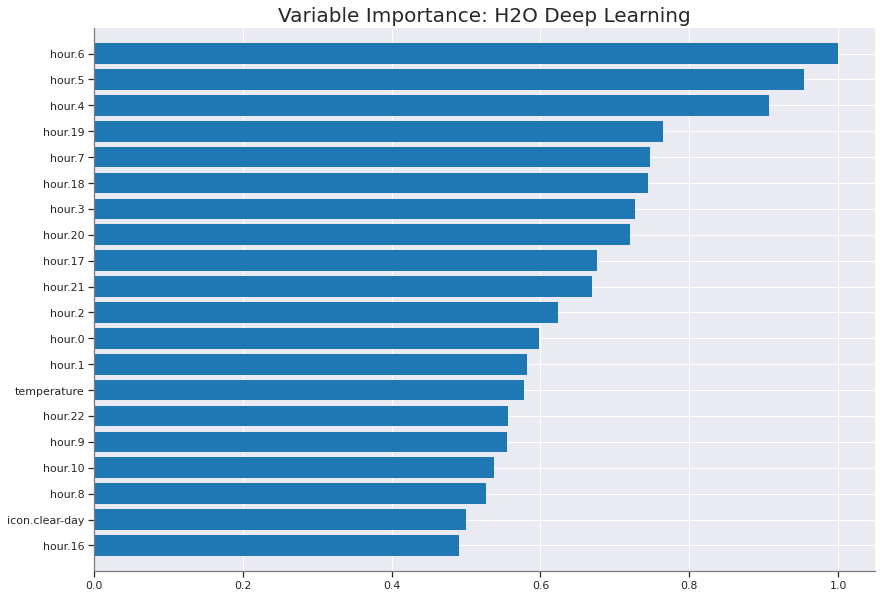

In [46]:
dl.varimp_plot(20)

<AxesSubplot:>

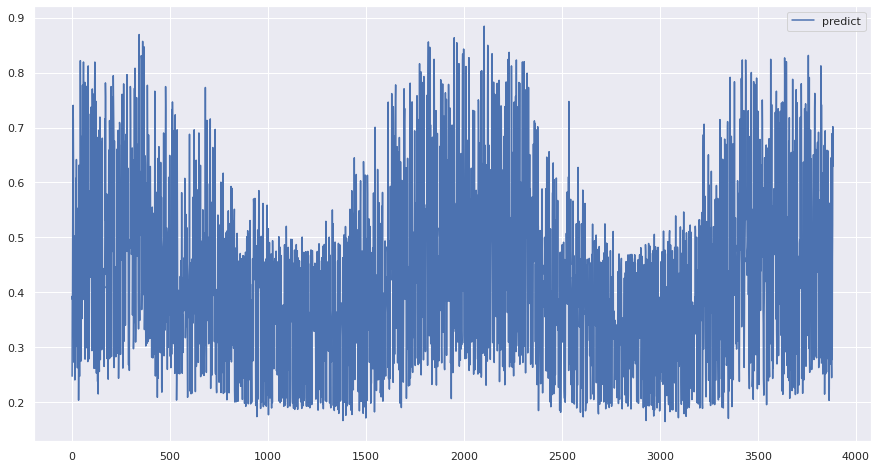

In [51]:
pred.as_data_frame().plot()

In [ ]:
# Fixed Effects Regression Model
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

fe_model = H2OGeneralizedLinearEstimator(
    
)


In [ ]:
# - local models
# - global models
# - local models with clusters "ensembles of exprts"

# Capture Performance
bench_reg_perf_train = bench_reg_model.model_performance(train)
bench_reg_perf_test = bench_reg_model.model_performance(test)

print(f'Benchmark Performance (AUC): {bench_reg_model.auc(train=True, valid=True, xval=True)}')
print(f'Benchmark Performance (AUCPR): {bench_reg_model.aucpr(train=True, valid=True, xval=True)}')
print(f'Benchmark Performance (MCC): {bench_reg_model.mcc(train=True, valid=True, xval=True)}')

print(bench_reg_model.confusion_matrix(train=True))
print(bench_reg_model.confusion_matrix(valid=True))

# Show top 20 features from variable importance - - algorithm specifc
bench_reg_model.varimp_plot(20)
